# Few-Shot Image Captioning with FlowMo

This notebook demonstrates how to perform 5-shot image captioning using the FlowMo model.
We'll load 5 example images from ImageNet, display them, and then perform 5-shot captioning on a 6th image.

In [1]:
import torch
from omegaconf import OmegaConf
from flowmo import train_utils
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import mediapy, einops
from few_shot_captioning import FewShotImageCaptioner

/svl/u/kevin02/miniconda3/envs/FlowMo/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load and Initialize the Model

First, let's initialize the captioner model.

In [2]:
# Initialize the captioner model
captioner = FewShotImageCaptioner(model_name="flowmo_hi_qwen2.5-coder-0.5b_span_0.3", device="cuda")

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Mup enabled!


## 2. Load Example Images from ImageNet

We'll load 6 images from ImageNet: 5 for examples and 1 for testing.

In [3]:
# Set up data loader
print("Loading ImageNet validation data...")
config = OmegaConf.load('flowmo/configs/base.yaml')
config.data.batch_size = 9  # Load 6 images: 5 for examples, 1 for testing
config.data.num_workers = 0

# Set a seed for reproducibility
torch.manual_seed(42)

# Load dataset to get sample images
val_dataloader = train_utils.load_dataset(config, 'val', shuffle_val=True)
batch = next(train_utils.wrap_dataloader([next(iter(val_dataloader))]))

# Get images
images = batch['image']

# Split into example images and test image
example_images = images[:5]  # First 5 images for examples
test_image = images[8]     # Last image for testing

print(f"Loaded {len(example_images)} example images and 1 test image")

Loading ImageNet validation data...
Loaded 5 example images and 1 test image


## 3. Display Example Images

Let's display the 5 example images.

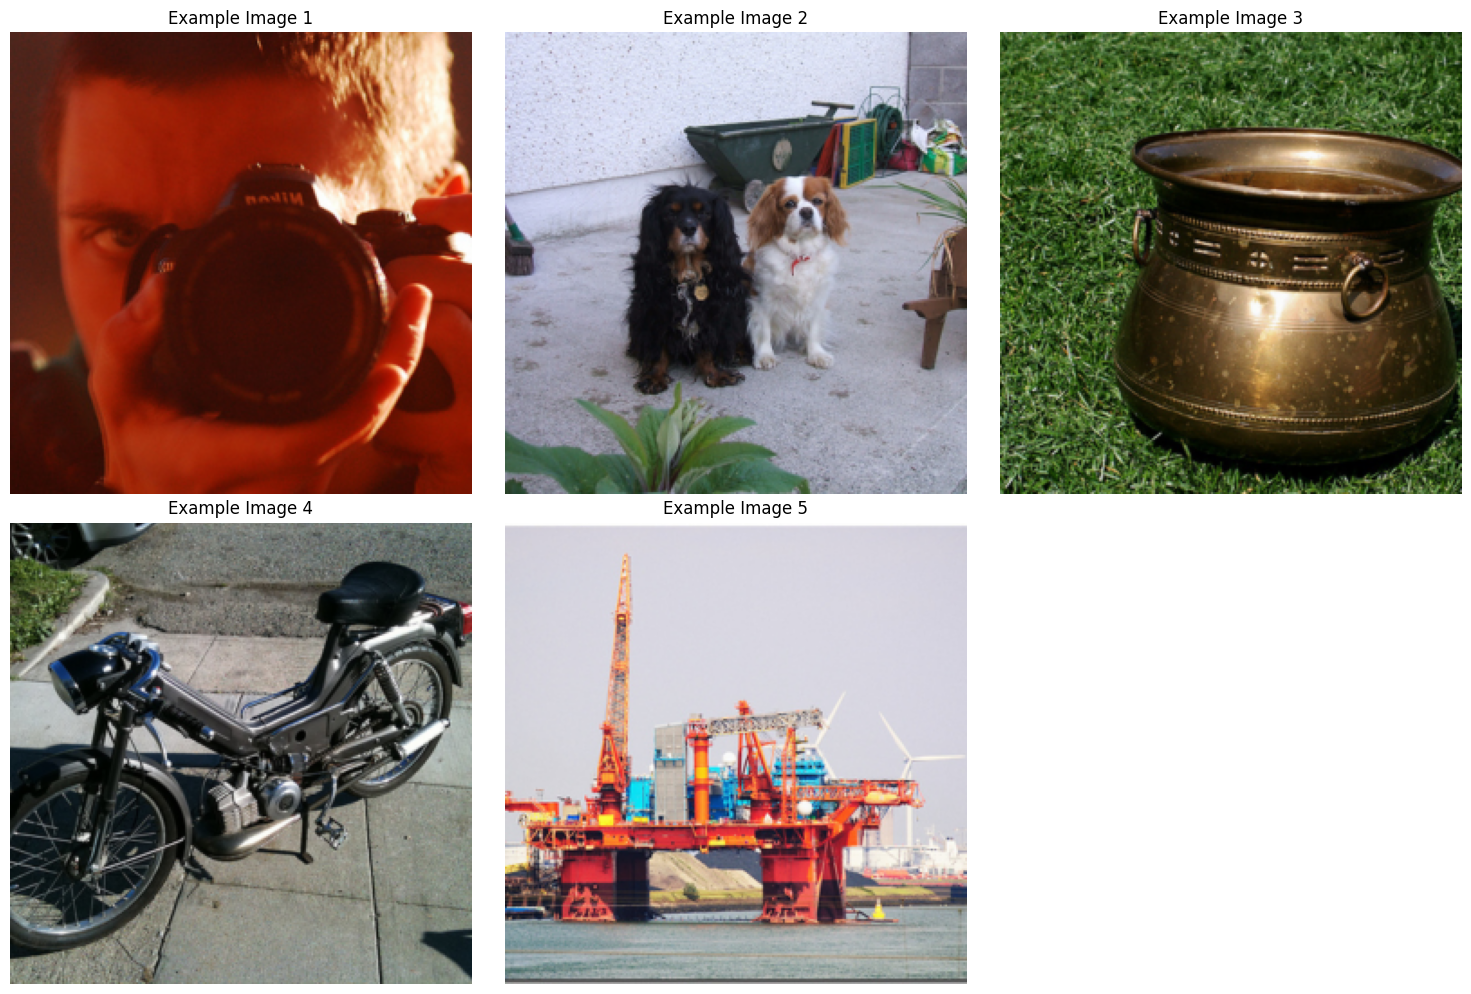

In [4]:
# Convert images from [-1, 1] to [0, 1] for display
def denorm_image(img):
    return img / 2 + 0.5

# Display the example images
plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(2, 3, i+1)
    img = denorm_image(example_images[i].cpu())
    img = einops.rearrange(img, "c h w -> h w c")
    plt.imshow(img)
    plt.title(f"Example Image {i+1}")
    plt.axis("off")
plt.tight_layout()
plt.show()

## 4. Provide Captions for Example Images

Please provide captions for the 5 example images. These will be used for 5-shot captioning.

In [5]:
# Add your captions for the example images here
example_caption_1 = "a man holding a black DSLR camera, pointing it directly towards the viewer"
example_caption_2 = "a black dog to the left of a white dog on a gray carpet floor with dog footprints"
example_caption_3 = "an antique brass pot resting on a patch of vibrant green grass"
example_caption_4 = "a classic-style moped parked outdoors on a paved sidewalk next to a curb"
example_caption_5 = "a large, bright orange semi-submersible oil rig situated in a harbor"

# Collect all example captions
example_captions = [
    example_caption_1,
    example_caption_2,
    example_caption_3,
    example_caption_4,
    example_caption_5
]

# Verify that captions have been provided
all_captions_provided = all(caption != "" for caption in example_captions)
if all_captions_provided:
    print("✅ All example captions provided. Ready for 5-shot captioning!")
else:
    print("❌ Please provide captions for all example images before proceeding.")

✅ All example captions provided. Ready for 5-shot captioning!


## 5. Display Test Image

Now let's display the test image that we'll caption using the 5-shot approach.

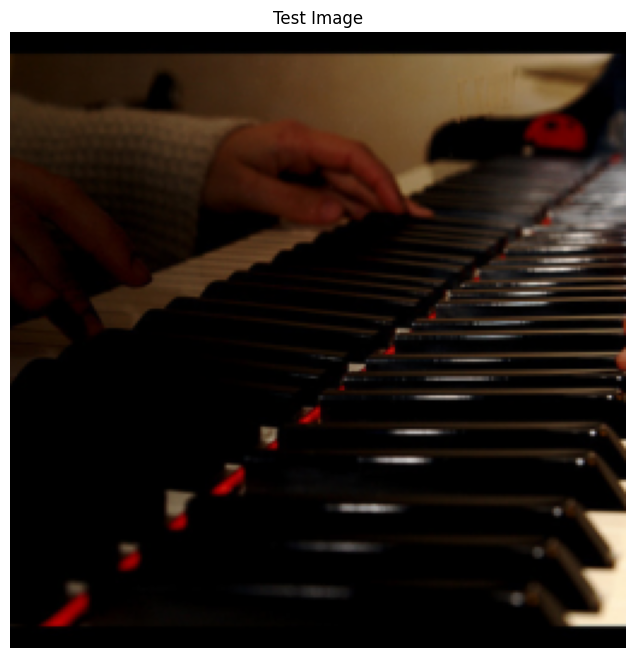

In [6]:
# Display the test image
plt.figure(figsize=(8, 8))
img = denorm_image(test_image.cpu())
img = einops.rearrange(img, "c h w -> h w c")
plt.imshow(img)
plt.title("Test Image")
plt.axis("off")
plt.show()

## 6. Perform 5-Shot Captioning

Finally, let's use the 5 example images and captions to generate a caption for the test image.

In [7]:
from transformers import AutoTokenizer

qwen_tokenizer = AutoTokenizer.from_pretrained(
    "Qwen/Qwen2.5-coder-0.5B",
    trust_remote_code=True
)

inputs = qwen_tokenizer('a hand playing piano is an image of', return_tensors="pt").to('cuda')
inputs

{'input_ids': tensor([[   64,  1424,  5619, 26278,   374,   458,  2168,   315]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [8]:
from transformers import AutoModelForCausalLM

qwen_model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2.5-coder-0.5B",
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
).to('cuda')

generated_ids = qwen_model.generate(
    **inputs,
    pad_token_id=qwen_tokenizer.pad_token_id,
)

qwen_tokenizer.decode(generated_ids[0], skip_special_tokens=True)

'a hand playing piano is an image of a person playing a musical instrument. The hand is the primary part of the body that is used to play the instrument. The hand is the primary part of the body that is used to play the instrument. The hand is the primary part of the body that is used to play the instrument. The hand is the primary part of the body that is used to play the instrument. The hand is the primary part of the body that is used to play the instrument. The hand is the primary part of the body that is used to play the instrument. The hand is the primary part of the body that is used to play the instrument. The hand is the primary part of the body that is used to play the instrument. The hand is the primary part of the body that is used to play the instrument. The hand is the primary part of the body that is used to play the instrument. The hand is the primary part of the body that is used to play the instrument. The hand is the primary part of the body that is used to play the 

In [9]:
import torch

# Get embeddings from input_ids defined in the previous cell
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']
inputs_embeds = qwen_model.get_input_embeddings()(input_ids).to(torch.bfloat16) # Ensure correct dtype

# Pass inputs_embeds instead of input_ids
generated_ids = qwen_model.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=attention_mask,
    pad_token_id=qwen_tokenizer.pad_token_id,
)

qwen_tokenizer.decode(generated_ids[0], skip_special_tokens=True)

' a person playing a musical instrument. The hand is the primary part of the body that is used to play the instrument. The hand is the primary part of the body that is used to play the instrument. The hand is the primary part of the body that is used to play the instrument. The hand is the primary part of the body that is used to play the instrument. The hand is the primary part of the body that is used to play the instrument. The hand is the primary part of the body that is used to play the instrument. The hand is the primary part of the body that is used to play the instrument. The hand is the primary part of the body that is used to play the instrument. The hand is the primary part of the body that is used to play the instrument. The hand is the primary part of the body that is used to play the instrument. The hand is the primary part of the body that is used to play the instrument. The hand is the primary part of the body that is used to play the instrument. The hand is the primary

In [10]:
# Check if captions are provided
if not all_captions_provided:
    print("Please provide captions for all example images before running 5-shot captioning.")
else:
    # Perform 5-shot captioning
    generated_caption = captioner.generate_caption(
        input_image=test_image,
        example_images=example_images[:3],
        example_captions=example_captions[:3],
        max_new_tokens=50,
    )
    
    print("Generated Caption:")
    print(generated_caption)

Generated Caption:
an antique grass. The green. 2. pointing it on a gray floor with dog footprints. 2. �。
